In [1]:
import pathlib
from tensorflow import keras
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import pickle
import math

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

def fitAndShow(model, model_name, train_data_generator, epochs, verbose=1, callbacks=[]):
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    try:
        model.load_weights('./weights/' + model_name + '.h5')
        print('Weights loaded...')
        with open('./histories/' + model_name + '-history', 'rb') as file:
            hist = pickle.load(file)
            print('History loaded...')
        model.evaluate(test_data_gen, verbose=verbose)
        print('Finished !')
    except:
        print('No weights or history saved for ' + model_name)
        hist = model.fit(
            train_data_generator,
            steps_per_epoch=STEPS_PER_EPOCH,
            epochs=epochs,
            validation_data=test_data_gen,
            validation_steps=VALIDATION_STEPS,
            verbose=verbose,
            callbacks=callbacks
        )
        model.save_weights('./weights/' + model_name + '.h5')
        with open('./histories/' + model_name + '-history', 'wb') as file:
            pickle.dump(hist.history, file)
        hist = hist.history
    
        
    plt.figure(figsize=(15, 6))
    plt.plot(range(0, len(hist.get('accuracy'))), hist.get('accuracy'), label="Training accuracy")
    plt.plot(range(0, len(hist.get('accuracy'))), hist.get('val_accuracy'), label="Test accuracy")
    plt.title("Accuracy of " + model_name)
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.legend()
    plt.show()
    
    model = model.predict(images_gen).argmax(axis=1)

    print('Result with our own images\n')
    print("Accuracy: ")
    print(accuracy_score(model, images_labels))
    print("\nConfusion matrix: ")
    print(confusion_matrix(model, images_labels))
    print("\n")
    print(classification_report(model, images_labels, target_names=CLASS_NAMES))

## Récupération des images

In [2]:
data_dir = pathlib.Path('./seg_train')
image_count = len(list(data_dir.glob('*/*.jpg')))

test_dir = pathlib.Path('./seg_test')
test_count = len(list(test_dir.glob('*/*.jpg')))

images_dir = pathlib.Path('./images')
images_count = len(list(images_dir.glob('*/*.jpg')))

## Récupération des différentes classes

In [3]:
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*')])
CLASS_NAMES

array(['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street'],
      dtype='<U9')

## Création des différentes variables

Pour le moment, on applique aucune augmentation d'image.

In [4]:
img_generator = ImageDataGenerator(rescale=1./255)
BATCH_SIZE = 32
IMG_HEIGHT = 150
IMG_WIDTH = 150
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)
VALIDATION_STEPS = np.ceil(test_count/BATCH_SIZE)

## Création des générateurs d'images

In [5]:
# Générateur des données d'entrainement, non augmentées
train_data_gen = img_generator.flow_from_directory(
    directory=str(data_dir),
    batch_size=BATCH_SIZE,
    shuffle=True,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary'
)

# Générateur des données de tests
test_data_gen = img_generator.flow_from_directory(
    directory=str(test_dir),
    batch_size=BATCH_SIZE,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary'
)

# Générateur des données à partir de nos propres images
images_gen = img_generator.flow_from_directory(
    directory=str(images_dir),
    batch_size=1,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary'
)

images_labels = []
for i in range(0, images_count):
    images_labels.extend(np.array(images_gen[i][1]))

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.
Found 12 images belonging to 6 classes.


## Création du 1er réseau de neuronnes

No weights or history saved for "model"
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 439.0 steps, validate for 94.0 steps
Epoch 1/10
439/439 [==============================] - 45s 102ms/step - loss: 1.2361 - accuracy: 0.5648 - val_loss: 0.8715 - val_accuracy: 0.6700
Epoch 2/10
439/439 [==============================] - 44s 100ms/step - loss: 0.6689 - accuracy: 0.7594 - val_loss: 0.7953 - val_accuracy: 0.7030
Epoch 3/10
439/439 [==============================] - 44s 100ms/step - loss: 0.3534 - accuracy: 0.8784 - val_loss: 0.8837 - val_accuracy: 0.7193
Epoch 4/10
439/439 [==============================] - 44s 101ms/step - loss: 0.1899 - accuracy: 0.9406 - val_loss: 1.0216 - val_accuracy: 0.7057
Epoch 5/10
439/439 [==============================] - 44s 100ms/step - loss: 0.1223 - accuracy: 0.9629 - val_loss: 1.1024 - val_accuracy: 0.7180
Epoch 6/10
439/439 [==============================] - 44s 100ms/step - loss: 0.0894 - accuracy: 0.9741 - val_loss: 1.2104 - val_accuracy: 

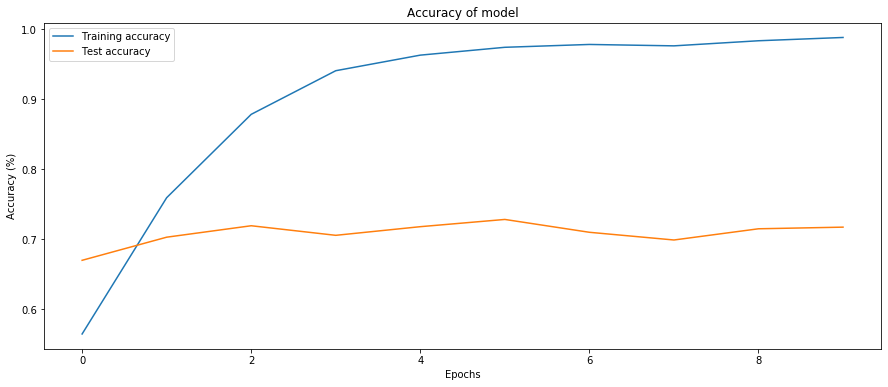

Result with our own images

Accuracy: 
0.6666666666666666

Confusion matrix: 
[[1 0 0 0 0 0]
 [0 2 0 0 0 0]
 [1 0 1 0 1 0]
 [0 0 0 2 1 0]
 [0 0 1 0 0 0]
 [0 0 0 0 0 2]]


              precision    recall  f1-score   support

   buildings       0.50      1.00      0.67         1
      forest       1.00      1.00      1.00         2
     glacier       0.50      0.33      0.40         3
    mountain       1.00      0.67      0.80         3
         sea       0.00      0.00      0.00         1
      street       1.00      1.00      1.00         2

    accuracy                           0.67        12
   macro avg       0.67      0.67      0.64        12
weighted avg       0.75      0.67      0.69        12



In [15]:
model = keras.Sequential([
    keras.layers.Conv2D(32, (5, 5), input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Flatten(), 
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(len(CLASS_NAMES), activation='softmax')
])

fitAndShow(model, 'model', train_data_gen, 10)

Grâce au graphique ci-dessus, on remarque une grosse différence entre la précision sur les données d'entrainement et les données de tests. On peut donc en déduire qu'il y a un surapprentissage.

## Création du 2ème réseau de neuronnes

On ajoute ici 3 nouvelles couches de convolution.

Weights loaded...
History loaded...
  ...
    to  
  ['...']
94/94 [==============================] - 5s 49ms/step - loss: 1.1854 - accuracy: 0.8163
Finished !


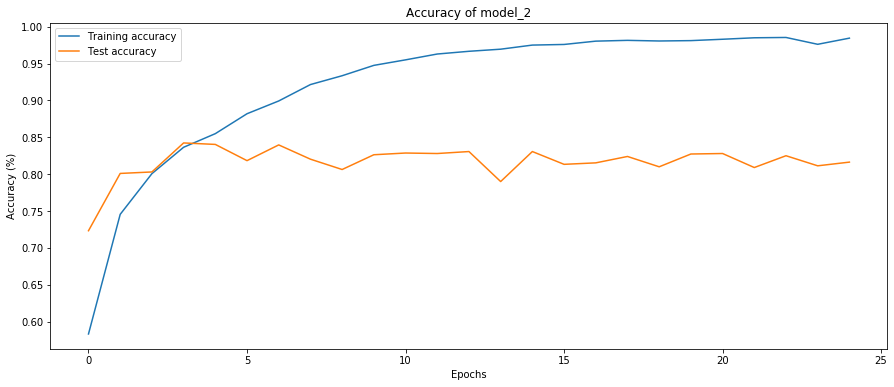

Result with our own images

Accuracy: 
0.75

Confusion matrix: 
[[1 0 0 0 0 0]
 [0 2 0 0 0 0]
 [0 0 1 1 0 0]
 [0 0 1 1 0 0]
 [0 0 0 0 2 0]
 [1 0 0 0 0 2]]


              precision    recall  f1-score   support

   buildings       0.50      1.00      0.67         1
      forest       1.00      1.00      1.00         2
     glacier       0.50      0.50      0.50         2
    mountain       0.50      0.50      0.50         2
         sea       1.00      1.00      1.00         2
      street       1.00      0.67      0.80         3

    accuracy                           0.75        12
   macro avg       0.75      0.78      0.74        12
weighted avg       0.79      0.75      0.76        12



In [7]:
model_2 = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Conv2D(32, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Conv2D(128, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Flatten(),  
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(len(CLASS_NAMES), activation='softmax')
])

fitAndShow(model_2, 'model_2', train_data_gen, 25)

Après avoir ajouter plusieurs couches de convolution à notre réseau de neuronnes, il y a toujours un apprentissage mais l'écart de précision entre le jeu de données d'entrainement et celui de test est réduit par rapport à notre premier modèle.

## Augmentation des images

In [8]:
aug_img_generator = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    brightness_range=[0.5, 1.5],
    zoom_range=.3
)

aug_train_data_gen = aug_img_generator.flow_from_directory(
    directory=str(data_dir),
    batch_size=BATCH_SIZE,
    shuffle=True,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary'
)

Found 14034 images belonging to 6 classes.


On ajoute du flip horizontale, on change la luminosité et on zoom/dézoom sur les images.

### Différents modèles avec les images augmentées

Weights loaded...
History loaded...
  ...
    to  
  ['...']
94/94 [==============================] - 4s 45ms/step - loss: 0.4280 - accuracy: 0.8707
Finished !


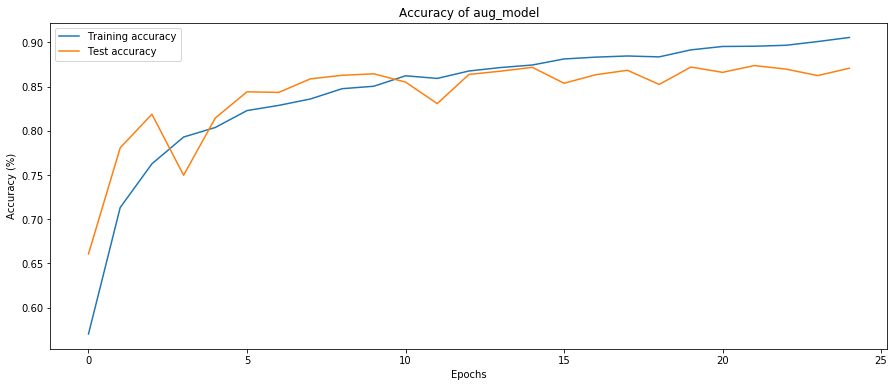

Result with our own images

Accuracy: 
0.9166666666666666

Confusion matrix: 
[[2 0 0 0 0 0]
 [0 2 0 0 0 0]
 [0 0 1 0 0 0]
 [0 0 0 2 0 0]
 [0 0 1 0 2 0]
 [0 0 0 0 0 2]]


              precision    recall  f1-score   support

   buildings       1.00      1.00      1.00         2
      forest       1.00      1.00      1.00         2
     glacier       0.50      1.00      0.67         1
    mountain       1.00      1.00      1.00         2
         sea       1.00      0.67      0.80         3
      street       1.00      1.00      1.00         2

    accuracy                           0.92        12
   macro avg       0.92      0.94      0.91        12
weighted avg       0.96      0.92      0.92        12



In [9]:
aug_model = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Conv2D(32, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Conv2D(128, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(len(CLASS_NAMES), activation='softmax')
])

fitAndShow(aug_model, 'aug_model', aug_train_data_gen, 25)

Weights loaded...
History loaded...
  ...
    to  
  ['...']
94/94 [==============================] - 4s 46ms/step - loss: 0.4491 - accuracy: 0.8507
Finished !


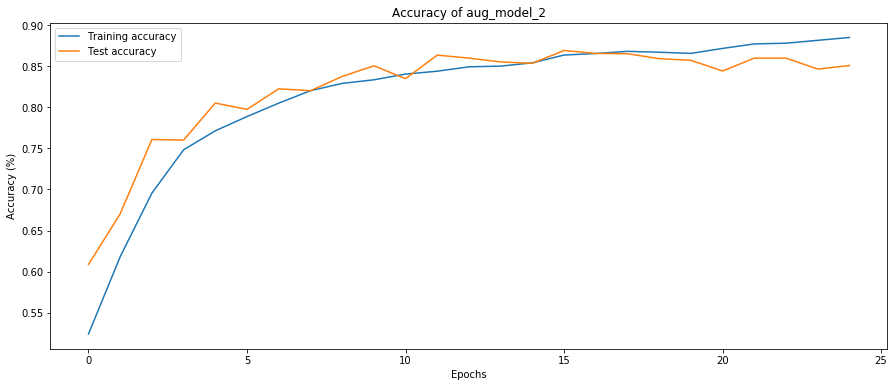

Result with our own images

Accuracy: 
0.8333333333333334

Confusion matrix: 
[[2 0 0 0 0 0]
 [0 2 0 0 0 0]
 [0 0 1 1 0 0]
 [0 0 0 1 0 0]
 [0 0 1 0 2 0]
 [0 0 0 0 0 2]]


              precision    recall  f1-score   support

   buildings       1.00      1.00      1.00         2
      forest       1.00      1.00      1.00         2
     glacier       0.50      0.50      0.50         2
    mountain       0.50      1.00      0.67         1
         sea       1.00      0.67      0.80         3
      street       1.00      1.00      1.00         2

    accuracy                           0.83        12
   macro avg       0.83      0.86      0.83        12
weighted avg       0.88      0.83      0.84        12



In [10]:
aug_model_2 = keras.Sequential([
    keras.layers.Conv2D(32, (5, 5), input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Conv2D(32, (5, 5), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Conv2D(128, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(len(CLASS_NAMES), activation='softmax')
])

fitAndShow(aug_model_2, 'aug_model_2', aug_train_data_gen, 25)

Weights loaded...
History loaded...
  ...
    to  
  ['...']
94/94 [==============================] - 5s 49ms/step - loss: 0.5098 - accuracy: 0.8487
Finished !


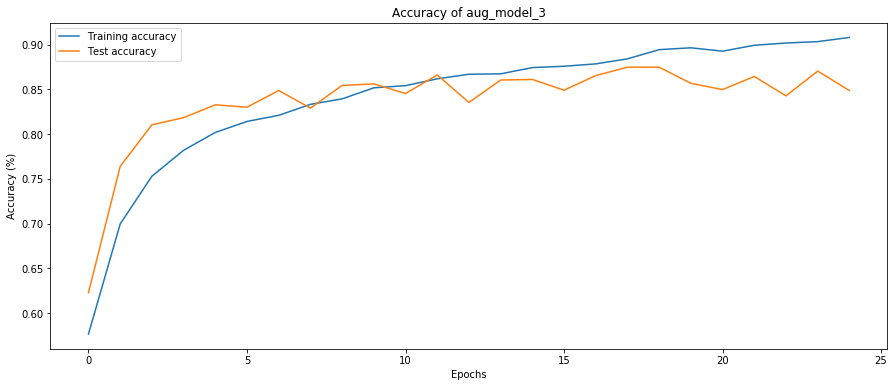

Result with our own images

Accuracy: 
0.8333333333333334

Confusion matrix: 
[[2 0 0 0 0 0]
 [0 2 0 0 0 0]
 [0 0 1 1 0 0]
 [0 0 0 1 0 0]
 [0 0 1 0 2 0]
 [0 0 0 0 0 2]]


              precision    recall  f1-score   support

   buildings       1.00      1.00      1.00         2
      forest       1.00      1.00      1.00         2
     glacier       0.50      0.50      0.50         2
    mountain       0.50      1.00      0.67         1
         sea       1.00      0.67      0.80         3
      street       1.00      1.00      1.00         2

    accuracy                           0.83        12
   macro avg       0.83      0.86      0.83        12
weighted avg       0.88      0.83      0.84        12



In [11]:
aug_model_3 = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), padding='same', activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Conv2D(32, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Conv2D(128, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(len(CLASS_NAMES), activation='softmax')
])

fitAndShow(aug_model_3, 'aug_model_3', aug_train_data_gen, 25)

Sur chacun de ces 3 modèles, on remarque que le surapprentissage est beaucoup moins important qu'avec nos premiers modèle. Cependant, aucun n'arrive à avoir une précision de 100% sur nos 12 images de test.

## Modèle avec les meilleurs hyperparamètres

Pour ce modèle, nous avons utilisé les mêmes couches avec les mêmes paramètres que **KerasTuner** nous a donné (_voir ./tuner/trial_f34f933341f1e29dd493bfe340ae3578/trial.json_)

Weights loaded...
History loaded...
  ...
    to  
  ['...']
94/94 [==============================] - 11s 117ms/step - loss: 0.4953 - accuracy: 0.8277
Finished !


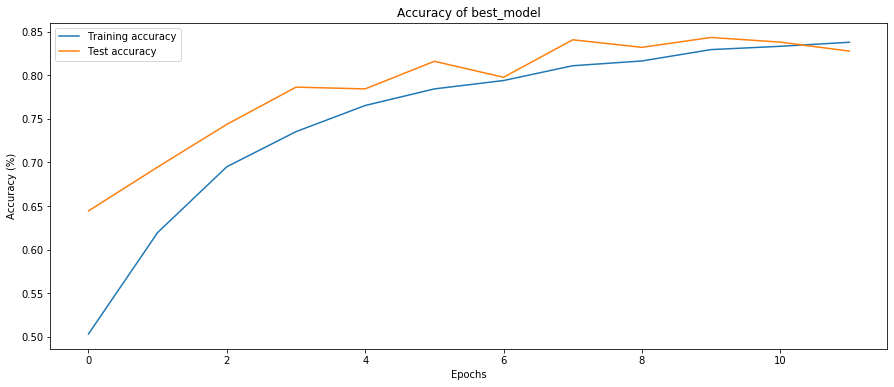

Result with our own images

Accuracy: 
1.0

Confusion matrix: 
[[2 0 0 0 0 0]
 [0 2 0 0 0 0]
 [0 0 2 0 0 0]
 [0 0 0 2 0 0]
 [0 0 0 0 2 0]
 [0 0 0 0 0 2]]


              precision    recall  f1-score   support

   buildings       1.00      1.00      1.00         2
      forest       1.00      1.00      1.00         2
     glacier       1.00      1.00      1.00         2
    mountain       1.00      1.00      1.00         2
         sea       1.00      1.00      1.00         2
      street       1.00      1.00      1.00         2

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12



In [14]:
best_model = keras.Sequential([
    keras.layers.Conv2D(112, (5, 5), input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), padding='same', activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Conv2D(112, (5, 5), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Conv2D(128, (5, 5), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Conv2D(64, (5, 5), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(1, 1)),
    keras.layers.Flatten(),
    keras.layers.Dense(96, activation='relu'),
    keras.layers.Dense(96, activation='relu'),
    keras.layers.Dense(96, activation='relu'),
    keras.layers.Dropout(0.13255806623970934),
    keras.layers.Dense(len(CLASS_NAMES), activation='softmax')
])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)

fitAndShow(best_model, 'best_model', aug_train_data_gen, 25, callbacks=[callback])